In [1]:
import sys
sys.path.append("..")

import numpy as np
import numpy.linalg as LA
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import control

import time
import meshcat

from flightcontrol.Quadcopter import *
from flightcontrol.Controller import *
from flightcontrol.Utils import *
from flightcontrol.Visualise import *

# Create a new visualizer
vis = meshcat.Visualizer()

# Specify physical parameters
params = { 'mass': 1, 'J': np.array([0.01, 0.01, 0.02])}

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


### Compute Control Law
For the state-space system

$ \dot{x} = Ax + Bu $

Find the control law $u = -Kx$ \
such that the closed-loop system

$ \dot{x} = (A-BK) x $

has the desired response

In [2]:
# Compute state feedback
z3 = np.zeros((3,3))
I3 = np.eye(3)
A = np.block([[z3, I3],[z3, z3]])
B = np.block([[z3],[I3]])
p = np.repeat([-3,-4], 3)
kTranslation = control.place(A, B, p)

# Compute state feedback
z3 = np.zeros((3,3))
I3 = np.eye(3)
A = np.block([[z3, I3],[z3, z3]])
B = np.block([[z3],[I3]])
p = np.repeat([-10,-12], 3)
kRotation = control.place(A, B, p)

# Instantiate Controller
controller = Controller(kTranslation, kRotation)

### Generate Trajectory and Run Simulation
Specify the trajectory as a function of time in `ref_function`

In [3]:
%%time

# Generate trajectory
def ref_function(t):
    t = np.atleast_1d(t)
    nan  = np.nan * t
    zero = 0 * t
    
    ref = {}
    ref['pos']  = np.stack(np.squeeze( [nan, nan, nan ] ))
    ref['vel']  = np.stack(np.squeeze( [nan, nan, nan ] ))
    ref['att']  = np.stack(np.squeeze( [nan, nan, zero] ))
    ref['rate'] = np.stack(np.squeeze( [nan, nan, nan ] ))
    
    ref['pos'][0] = 5*np.sin(1*t)
    ref['pos'][1] = 5*np.sin(0.5*t)
    ref['pos'][2] = -1 * (t > 0).astype(int)
    # ref['att'][0] = 0.5*np.sin(2*t)
    # ref['att'][1] = 0.5*np.sin(1*t)
    # ref['att'][2] = 0*np.sin(5*t)
    
    return ref

# Run Simulation
Ts     = 1/100
t_span = [0,20]
t_eval = np.arange(t_span[0], t_span[1], Ts)

# Instantiate Quadcopter
quadcopter = Quadcopter(params, ref_function, controller, 'Quaternion')

# Run simulation (solve ODE)
sol = solve_ivp(quadcopter, t_span, quadcopter.x0(), t_eval=t_eval)

# Unpack state & reference
t = sol.t
state = quadcopter.unpack_state(sol.y)
ref = ref_function(sol.t)

# Recreate control input
u = np.zeros((4, len(t)))
for i in range(len(t)):
    x = quadcopter.unpack_state(sol.y[:,i])
    r = ref_function(t[i])
    u[:,i] = controller(r, x)
T = u[0]
LMN = u[1:4]

Wall time: 1.8 s


Text(0.5, 1.0, 'Rate')

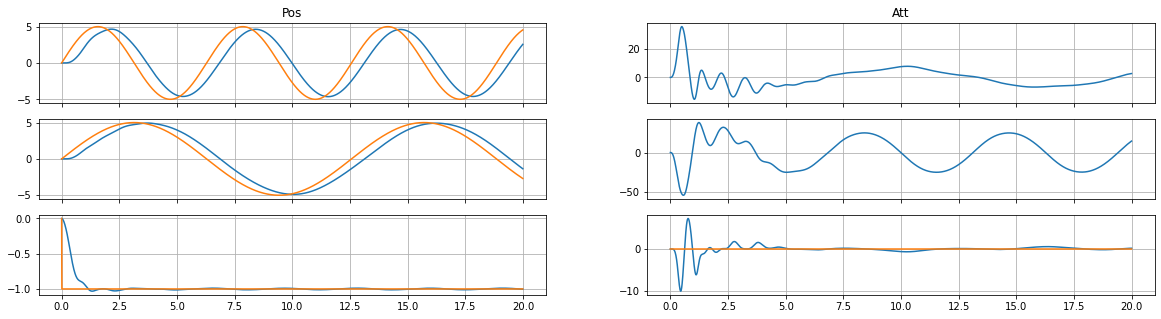

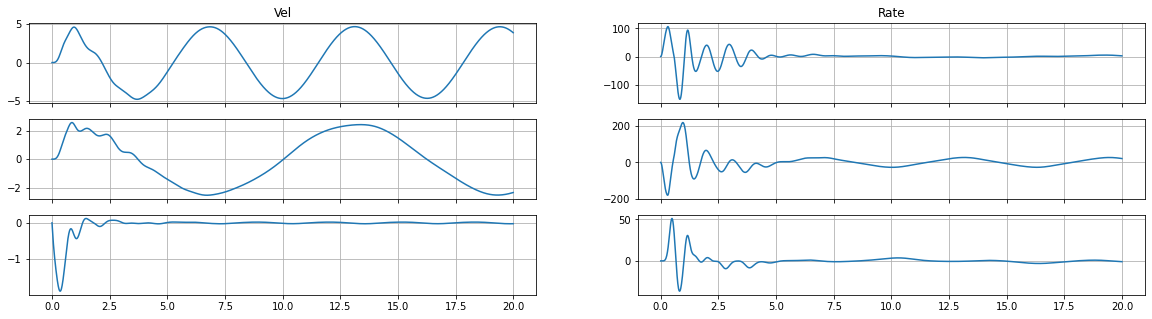

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

fig,ax = plt.subplots(3,2, sharex=True)
for i in range(3):
    ax[i,0].plot(t, state['pos'][i])
    ax[i,0].plot(t, ref['pos'][i])
    
    ax[i,1].plot(t, np.rad2deg(state['eul'][i]))
    ax[i,1].plot(t, np.rad2deg(ref['att'][i]))

[ ax[i,j].grid() for i in range(3) for j in range(2) ]
ax[0,0].set_title('Pos')
ax[0,1].set_title('Att')

fig,ax = plt.subplots(3,2, sharex=True)
for i in range(3):
    ax[i,0].plot(t, state['vel'][i])
    ax[i,0].plot(t, ref['vel'][i])
    
    ax[i,1].plot(t, np.rad2deg(state['rate'][i]))
    ax[i,1].plot(t, np.rad2deg(ref['rate'][i]))
    # ax[i,3].plot(time, LMN[i])
    
[ ax[i,j].grid() for i in range(3) for j in range(2) ]
ax[0,0].set_title('Vel')
ax[0,1].set_title('Rate')

### Visualise

In [5]:
# Reinitialise Meshcat scene
vis.delete()
drone = create_quadcopter(vis)
move_camera(vis, axis=[0,0,1], angle=45, offset=[3,3,1])

# Animate and save scene, then render as static snapshot
anim = meshcat.animation.Animation()
for i in range(0, len(t), 10):   
    with anim.at_frame(vis, i) as frame:
        frame.set_transform(homogeneous_transform_NED(state['eul'][:,i], state['pos'][:,i]))

vis.set_animation(anim)
vis.render_static()